In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["date"])
df

,tmax,date,prcp,snow,humidity,precipitation,precip_probability,precip_type,wind_speed,wind_direction,...,nasa_temp_min_rolling_mean7,nasa_temp_min_rolling_std7,nasa_temp_min_rolling_mean14,nasa_temp_min_rolling_std14,nasa_temp_min_rolling_mean30,nasa_temp_min_rolling_std30,day,dayofyear,dayofweek,season
0,39.02,2015-01-01,0.00,0.0,37.9,0.000,0.0,NaN,11.4,250.2,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,3,Winter
1,39.56,2015-01-02,0.00,0.0,40.7,0.000,0.0,NaN,15.1,270.1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,2,4,Winter
2,39.56,2015-01-03,0.71,0.0,67.9,0.670,100.0,"['rain', 'snow']",9.2,71.1,...,NaN,NaN,NaN,NaN,NaN,NaN,3,3,5,Winter
3,42.08,2015-01-04,0.30,0.0,86.7,0.351,100.0,['rain'],13.9,246.7,...,NaN,NaN,NaN,NaN,NaN,NaN,4,4,6,Winter
4,40.82,2015-01-05,0.00,0.0,36.3,0.000,0.0,NaN,22.8,290.8,...,NaN,NaN,NaN,NaN,NaN,NaN,5,5,0,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3282,41.00,2023-12-27,0.32,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.780000,3.775160,-0.570000,3.285525,-0.273000,3.290928,27,361,2,Winter
3283,41.90,2023-12-28,1.22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.481429,4.003804,-0.082143,3.558957,-0.120667,3.421544,28,362,3,Winter
3284,41.90,2023-12-29,0.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.112857,4.047706,0.677857,3.884884,0.200000,3.633173,29,363,4,Winter
3285,40.28,2023-12-30,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.327143,2.662816,1.047143,3.909630,0.429333,3.628948,30,364,5,Winter


In [5]:


def is_rain_or_snow(x):
    if isinstance(x, str):
        x = x.lower()
        return int("rain" in x or "snow" in x)
    return 0

df['rain_or_snow'] = df['precip_type'].apply(is_rain_or_snow)



In [6]:
# === 3. 仅保留数值型特征（KNN要求所有特征为数值）===
drop_cols = ['date', 'precip_type', 'season', 'rain_or_snow']
X = df.drop(columns=drop_cols)
X = X.select_dtypes(include=[np.number])  # 保留数值列
y = df['rain_or_snow']



In [7]:
# === 4. 缺失值填充 + 标准化 ===
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# === 5. 划分训练集与测试集 ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

# === 6. 训练 KNN 模型 ===
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# === 7. 预测与评估 ===
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print(f"=== AUC Score: {roc_auc_score(y_test, y_prob):.4f} ===")


C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['ms_wind_gust']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       547
           1       0.94      0.66      0.77       111

    accuracy                           0.93       658
   macro avg       0.94      0.82      0.87       658
weighted avg       0.93      0.93      0.93       658

=== AUC Score: 0.9512 ===


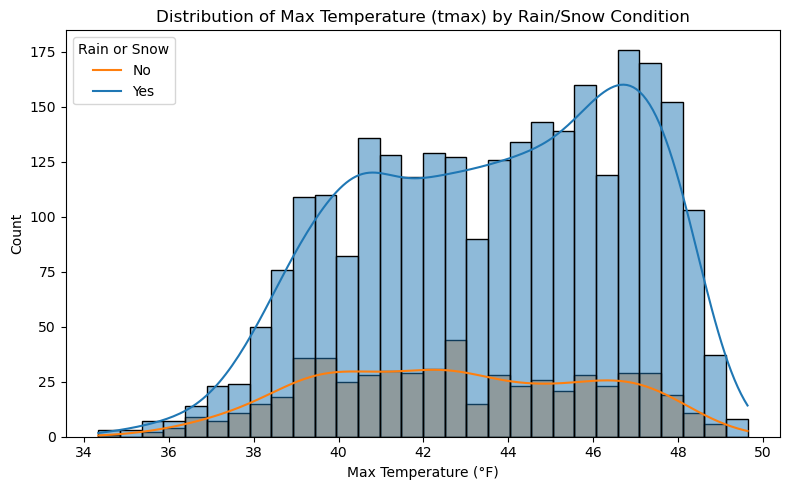

In [10]:
df['rain_or_snow'] = df['precip_type'].astype(str).str.lower().apply(
    lambda x: int("rain" in x or "snow" in x)
)

# Plot 1: Distribution of tmax by rain/snow condition
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='tmax', hue='rain_or_snow', kde=True, bins=30)
plt.title("Distribution of Max Temperature (tmax) by Rain/Snow Condition")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("Count")
plt.legend(title="Rain or Snow", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


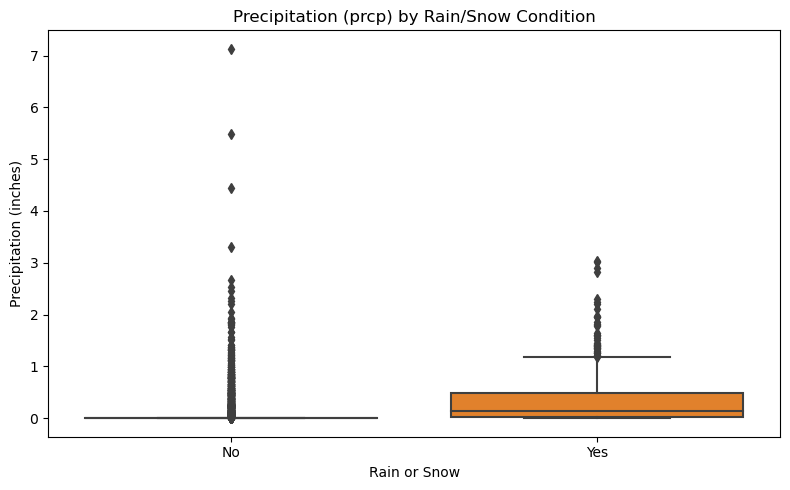

In [11]:

# Plot 2: Daily precipitation vs rain_or_snow
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='rain_or_snow', y='prcp')
plt.title("Precipitation (prcp) by Rain/Snow Condition")
plt.xlabel("Rain or Snow")
plt.ylabel("Precipitation (inches)")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()


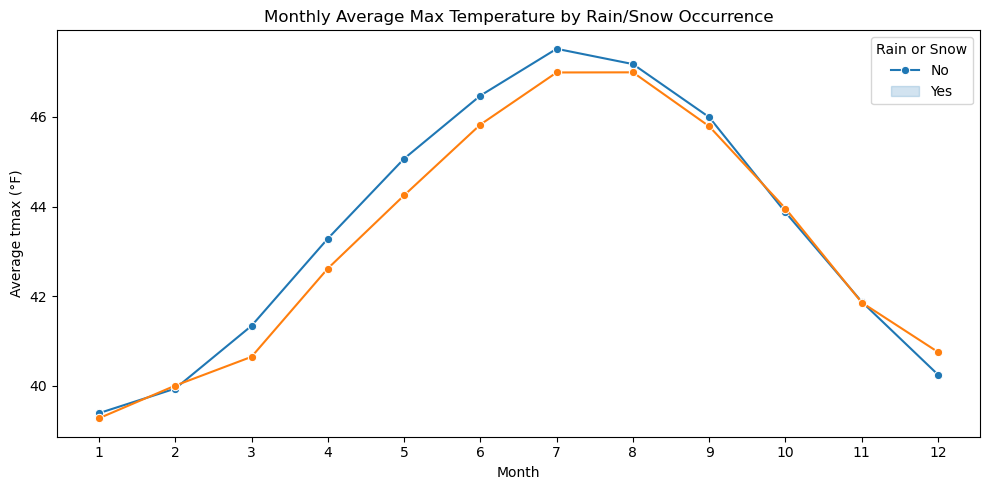

In [12]:
# Plot 3: Average tmax per month colored by rain/snow days
df['month'] = df['date'].dt.month
monthly_avg = df.groupby(['month', 'rain_or_snow'])['tmax'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x='month', y='tmax', hue='rain_or_snow', marker="o")
plt.title("Monthly Average Max Temperature by Rain/Snow Occurrence")
plt.xlabel("Month")
plt.ylabel("Average tmax (°F)")
plt.legend(title="Rain or Snow", labels=["No", "Yes"])
plt.xticks(ticks=range(1,13))
plt.tight_layout()
plt.show()